## Shortlist d'articles

Le but de ce notebook est de déterminer une liste restreinte d'articles, statique ou dynamique, qui sera utilisée pour les modélisations.

On se basera pour cela sur les ventes, couplées aux critères suivants : 
- Groupe de client
- Groupe de code postal
- Âge du client
- Catégories préférées par le client
- Articles susceptibles d'être rachetés
- Articles qui vont de pair avec des articles déjà achetés

**L'idée est de déterminer une liste de 50 articles par client, sur la base de laquelle le score maximal obtenu sera satisfaisant.**

In [1]:
import pandas as pd
import numpy as np

ages_centers = [15, 25, 35, 45, 55, 65]

def get_maximum_score(purchased_articles, shortlist):
    """Get the maximum (linear) score that can be obtained with an article shortlist.

    Args:
        purchased_articles (pd.Series): Series containing the list of purchased article for each customer.
        shortlist (pd.Series): Series containing the shortlist of articles for each customer.
        
        
    Returns:
        A pd.Series object containing the maximum linear score for each customer.
    """
    return pd.concat([purchased_articles.rename('purchased_articles'), shortlist.rename('shortlist')], axis = 1).apply(
        lambda x: min( 
            np.sum(
                np.where(
                    [article in x.purchased_articles for article in x.shortlist], # Gives one sub-point for right article.
                    1, 
                    0
                )
            ) / min(len(x.purchased_articles), 12), # Predict 12 articles is sufficient for having the maximum score.
            1 # The max score is 1 per article.
        ),
    axis=1)

def map12_score_table():
    """Get a score array for MAP@12.

    Returns:
        An array that gives the maximum score contribution for each position in the list.
    """
        
    # Get a table containing the subscore for each position, depending on the purchased article length.
    score_table = np.zeros(12)
    
    for position in range(0, 12):
        for i in range(position, 12): # iterate on each time the article intervenes on the score.
            score_table[position] += 1 / (i + 1)

    score_table = score_table / np.sum(score_table)
    
    return score_table

def map12(purchased_articles, prediction):
    """Process the map12 score from the purchased articles and a prediction.

    Args:
        purchased_articles (pd.Series): the list of purchased articles for each customer
        prediction (pd.Series): the prediction (list format) for each customer.
        
    Returns:
        A pd.Series object containing the score for each customer.
    """
    
    return pd.concat([purchased_articles.rename('purchased_articles'), prediction.rename('prediction')], axis = 1).apply(
        lambda x: np.sum(
            np.fromiter(
                (np.where(
                x.prediction[cutoff] in x.purchased_articles,
                np.sum(
                    np.fromiter(
                        (np.where(
                            x.prediction[position] in x.purchased_articles,
                            1 / (cutoff + 1), 
                            0
                        ) for position in range(0, cutoff + 1)),
                        float
                    )
                ),
                0
            ) for cutoff in range(0, min(len(x.prediction), 12)) ),
            float)
        ) / min(len(x.purchased_articles), 12),
    axis=1)
    
def max_score_curve(purchased_articles, shortlist, max = 50, step = 5):
    curve = [0]
    
    length = len(shortlist)
    
    score = 0
    
    for i in np.arange(0, max, step):
        print(f"\r Calcul pour les articles 1-{i}", end="")
        score += get_maximum_score(
                purchased_articles,
                shortlist.apply(lambda x: x[i: i + step])
            ).sum() / length
            
        curve.append(
            score
        )
    
    return curve

### Création des données de validations
-> Sur la base de la dernière semaine du jeu de données

In [2]:
transactions = pd.read_pickle('pickles/transactions.pkl')
transactions_last_week = transactions[transactions['week_number'] == 0]

In [3]:
validation_purchases = transactions_last_week.groupby(['customer_id'], as_index = False).agg(
    purchase_list = ('article_id', lambda x: list(x))
)

In [4]:
transactions.groupby('week_number')['customer_id'].nunique().describe()

count       105.000000
mean      76917.314286
std       15344.606781
min       49127.000000
25%       68004.000000
50%       73096.000000
75%       80937.000000
max      134010.000000
Name: customer_id, dtype: float64

### Création des listes pour chaque Client
Ici, on travaille uniquement sur les clients qui ont des achats.

In [5]:
customers = pd.read_pickle('pickles/customers_second_iteration.pkl')
articles = pd.read_pickle('pickles/articles_second_iteration.pkl')

In [6]:
before_last_week_sales = transactions[transactions['week_number'] == 1]

In [8]:

validation_customers = validation_purchases[['customer_id']].merge(customers, on = 'customer_id', how = 'left')
validation_customers.drop(['FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age', 'average_cart_articles',
       'average_cart_price', 'total_carts', 'total_articles', 'total_price',
       'average_cart_interval', 'repurchases', 'repurchases_interval'], 1, inplace = True)
before_last_week_sales = transactions[transactions['week_number'] == 1].merge(customers, on = 'customer_id', how = 'left')

/tmp/ipykernel_5768/158463998.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  validation_customers.drop(['FN', 'Active', 'club_member_status',


In [9]:
top_sales_validation = before_last_week_sales.groupby(['article_id', 'postal_code_group', 'group'], as_index = False).agg(
    sales = ('article_id', 'count'),
    age_around_15 = ('age_around_15', 'sum'),
    age_around_25 = ('age_around_25', 'sum'),
    age_around_35 = ('age_around_35', 'sum'),
    age_around_45 = ('age_around_45', 'sum'),
    age_around_55 = ('age_around_55', 'sum'),
    age_around_65 = ('age_around_65', 'sum'),
)

    
# Add index group
top_sales_validation = top_sales_validation.merge(articles[['article_id', 'index_group_name']], on = 'article_id')
top_sales_validation

,article_id,postal_code_group,group,sales,age_around_15,age_around_25,age_around_35,age_around_45,age_around_55,age_around_65,index_group_name
0,0108775044,4,4,1,0.0,0.0,0.0,0.2,0.8,0.0,Ladieswear
1,0108775044,5,5,1,0.0,0.3,0.7,0.0,0.0,0.0,Ladieswear
2,0111565001,1,1,1,0.1,0.9,0.0,0.0,0.0,0.0,Ladieswear
3,0111565001,1,4,1,0.0,0.0,0.0,0.5,0.5,0.0,Ladieswear
4,0111565001,1,5,1,0.0,0.5,0.5,0.0,0.0,0.0,Ladieswear
...,...,...,...,...,...,...,...,...,...,...,...
119311,0956217002,4,1,1,0.0,0.9,0.1,0.0,0.0,0.0,Ladieswear
119312,0956217002,4,3,2,0.0,0.0,0.0,0.0,0.7,1.2,Ladieswear
119313,0956217002,4,5,1,0.0,0.4,0.6,0.0,0.0,0.0,Ladieswear
119314,0956217002,4,6,3,0.2,2.5,0.3,0.0,0.0,0.0,Ladieswear


#### Articles les plus vendus

In [9]:
top_sales_general = top_sales_validation.groupby('article_id', as_index = False)['sales'].sum().nlargest(n = 100, columns="sales")['article_id'].tolist()
validation_customers['best_articles'] = validation_customers['customer_id'].apply(lambda x: top_sales_general)
validation_customers.head(5)

,customer_id,baby,divided,ladieswear,menswear,sport,age_around_15,age_around_25,age_around_35,age_around_45,age_around_55,age_around_65,postal_code_group,group,best_articles
0,00039306476aaf41a07fed942884f16b30abfa83a2a8be...,0.000000,0.161290,0.645161,0.193548,0.000000,0.0,0.8,0.2,0.0,0.0,0.0,1,1,"[0909370001, 0865799006, 0918522001, 092424300..."
1,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,0.000000,0.944444,0.055556,0.000000,0.000000,0.0,0.2,0.8,0.0,0.0,0.0,4,2,"[0909370001, 0865799006, 0918522001, 092424300..."
2,000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...,0.000000,0.875000,0.125000,0.000000,0.000000,0.0,0.6,0.4,0.0,0.0,0.0,1,0,"[0909370001, 0865799006, 0918522001, 092424300..."
3,000525e3fe01600d717da8423643a8303390a055c578ed...,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,5,6,"[0909370001, 0865799006, 0918522001, 092424300..."
4,00077dbd5c4a4991e092e63893ccf29294a9d5c46e8501...,0.055556,0.208333,0.694444,0.013889,0.027778,0.2,0.8,0.0,0.0,0.0,0.0,0,1,"[0909370001, 0865799006, 0918522001, 092424300..."


In [19]:
best_articles_map12 = map12(
    validation_purchases['purchase_list'],
    validation_customers['best_articles'].apply(lambda x: x[0:11])
)

best_articles_map12.sum() / len(best_articles_map12)

0.008336265044440449

#### Classement par groupe de code postal

In [20]:
postal_code_groups = top_sales_validation['postal_code_group'].unique()

postal_codes_lists = {}

top_sales_postal_code_groups = top_sales_validation.groupby(['article_id', 'postal_code_group'], as_index = False)['sales'].sum()

for group in postal_code_groups :
    postal_codes_lists[group] = top_sales_postal_code_groups[top_sales_postal_code_groups['postal_code_group'] == group].nlargest(n = 100, columns="sales")['article_id'].tolist()

validation_customers['postal_group_articles'] = validation_customers['postal_code_group'].apply(lambda x: postal_codes_lists[x])

#### Classement par groupe d'utilisateur

In [21]:
customer_groups = top_sales_validation['group'].unique()

customer_group_lists = {}

top_sales_customer_groups = top_sales_validation.groupby(['article_id', 'group'], as_index = False)['sales'].sum()

for group in customer_groups :
    customer_group_lists[group] = top_sales_customer_groups[top_sales_customer_groups['group'] == group].nlargest(n = 100, columns="sales")['article_id'].tolist()

validation_customers['customer_group_articles'] = validation_customers['group'].apply(lambda x: customer_group_lists[x])

#### Classement par catégorie

In [22]:
categories = top_sales_validation['index_group_name'].unique()
categories_string = []

top_sales_categories = top_sales_validation.groupby(['article_id', 'index_group_name'], as_index = False)['sales'].sum()

top_sales_category_lists = {}

for category in categories:
    category_string = category.split('/')[0].lower()
    categories_string.append(category_string)
    
    top_sales_category_lists[category_string] = top_sales_categories[top_sales_categories['index_group_name'] == category].nlargest(n = 100, columns = ['sales'])
    top_sales_category_lists[category_string]['shares'] = top_sales_category_lists[category_string]['sales'] / top_sales_category_lists[category_string]['sales'].sum()
    top_sales_category_lists[category_string]['index_group_name'] = category_string


In [48]:
def get_category_list(x, balanced = False):
    global categories
    global top_sales_category_lists
    
    top_sales_weighted = []
    
    for category in categories_string:
    
        if x[category] == 0:
            continue
        
        column = 'shares' if balanced else 'sales'
        
        top_sales_category_lists[category]['sales_weighted'] = top_sales_category_lists[category][column] * x[category]
        
        top_sales_weighted.append(top_sales_category_lists[category])
        
    return pd.concat(top_sales_weighted).nlargest(n = 100, columns = ['sales_weighted'])['article_id'].tolist()

def get_category_list_weighted(x):
    return get_category_list(x, balanced = True)

In [49]:
validation_customers['category_list'] = validation_customers.apply(get_category_list, axis = 1)


In [25]:
# liste utilisant les parts de vente dans chaque catégorie et non les ventes en valeur absolue.
validation_customers['category_list_balanced'] = validation_customers.apply(get_category_list_weighted, axis = 1)

#### Classement par âge (pondération discrète)

In [26]:
customer_age_lists = {}

top_sales_ages = top_sales_validation.groupby('article_id', as_index = False).agg(
    sales = ('sales', 'sum'),
    age_around_15 = ('age_around_15', 'sum'),
    age_around_25 = ('age_around_25', 'sum'),
    age_around_35 = ('age_around_35', 'sum'),
    age_around_45 = ('age_around_45', 'sum'),
    age_around_55 = ('age_around_55', 'sum'),
    age_around_65 = ('age_around_65', 'sum'),
)

validation_customers['age_articles'] = ''

for age in ages_centers :
    age_list = top_sales_ages.nlargest(n = 100, columns=f"age_around_{age}")['article_id'].tolist()
    
    validation_customers['age_articles'] = validation_customers.apply(
        lambda x: 
            age_list if x[f"age_around_{age}"] > 0.5 
            else x['age_articles']
        , axis = 1
    )

#### Classement par âge (pondération continue)

In [27]:
def age_weighted_list(x):
    global top_sales_ages
    
    top_sales_ages['sales_weighted'] = 0
    
    for age in ages_centers:
        column = f'age_around_{age}'
        top_sales_ages['sales_weighted'] += top_sales_ages[column] * x[column]
        
    return top_sales_ages.nlargest(n = 100, columns = ['sales_weighted'])['article_id'].tolist()


validation_customers['age_articles_weighted'] = validation_customers.apply(age_weighted_list, axis = 1)

In [29]:
validation_purchases.to_pickle('pickles/second_iteration_validation_purchases.pkl')
validation_customers.to_pickle('pickles/second_iteration_shortlists.pkl')

In [39]:
best_articles_curve = max_score_curve(validation_purchases['purchase_list'], validation_customers['best_articles'])

 Calcul pour les articles 1-50

In [40]:
postal_group_curve = max_score_curve(validation_purchases['purchase_list'], validation_customers['postal_group_articles'])

 Calcul pour les articles 1-50

In [41]:
customer_group_curve = max_score_curve(validation_purchases['purchase_list'], validation_customers['customer_group_articles'])

 Calcul pour les articles 1-50

In [50]:
category_list_curve = max_score_curve(validation_purchases['purchase_list'], validation_customers['category_list'])

 Calcul pour les articles 1-50

In [43]:
category_list_balanced_curve = max_score_curve(validation_purchases['purchase_list'], validation_customers['category_list_balanced'])

 Calcul pour les articles 1-50

In [44]:
age_curve = max_score_curve(validation_purchases['purchase_list'], validation_customers['age_articles'])

 Calcul pour les articles 1-50

In [45]:
age_weighted_curve = max_score_curve(validation_purchases['purchase_list'], validation_customers['age_articles_weighted'])

 Calcul pour les articles 1-50

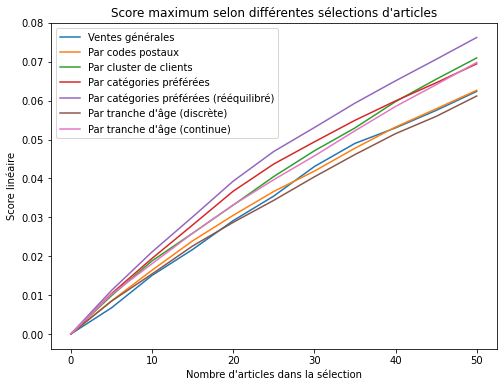

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

x = np.arange(0, 51, 5)

plt.figure(figsize = (8, 6))
plt.plot(x, best_articles_curve, label = "Ventes générales")
plt.plot(x, postal_group_curve, label = "Par codes postaux")
plt.plot(x, customer_group_curve, label = "Par cluster de clients")
plt.plot(x, category_list_curve, label = "Par catégories préférées")
plt.plot(x, category_list_balanced_curve, label = "Par catégories préférées (rééquilibré)")
plt.plot(x, age_curve, label = "Par tranche d'âge (discrète)")
plt.plot(x, age_weighted_curve, label = "Par tranche d'âge (continue)")

plt.xlabel("Nombre d'articles dans la sélection")
plt.ylabel("Score linéaire")
plt.title("Score maximum selon différentes sélections d'articles")
plt.legend()

plt.show()

Les listes par âge (pondération continue), clustering de clients et surtout catégories préférées rééquilibrée offrent un gain potentiel significatif.
Il serait donc opportun de croiser ses différentes listes.

#### Sélection croisée Groupe / Catégorie / Âge

In [10]:
# Préparation des classements.

groups = top_sales_validation['group'].unique()
categories = top_sales_validation['index_group_name'].unique()

cross_lists = {}

top_sales_cross = top_sales_validation.groupby(['article_id', 'index_group_name', 'group'], as_index = False).agg(
    sales = ('sales', 'sum'),
    age_around_15 = ('age_around_15', 'sum'),
    age_around_25 = ('age_around_25', 'sum'),
    age_around_35 = ('age_around_35', 'sum'),
    age_around_45 = ('age_around_45', 'sum'),
    age_around_55 = ('age_around_55', 'sum'),
    age_around_65 = ('age_around_65', 'sum'),
)

for group in groups :
    cross_lists[group] = {}
    
    categories = top_sales_validation['index_group_name'].unique()

    for category in categories:
        category_string = category.split('/')[0].lower()
        
        cross_lists[group][category_string] = top_sales_cross[(top_sales_cross['group'] == group) & (top_sales_cross['index_group_name'] == category)]
        cross_lists[group][category_string]['shares'] = cross_lists[group][category_string]['sales'] / cross_lists[group][category_string]['sales'].sum()
        cross_lists[group][category_string]['index_group_name'] = category_string
        cross_lists[group][category_string] = cross_lists[group][category_string].nlargest(n = 100, columns = 'shares')

/tmp/ipykernel_5768/1261146488.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_lists[group][category_string]['shares'] = cross_lists[group][category_string]['sales'] / cross_lists[group][category_string]['sales'].sum()
/tmp/ipykernel_5768/1261146488.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_lists[group][category_string]['index_group_name'] = category_string


In [11]:
def get_cross_list(x):
    global cross_lists
    
    top_sales_weighted = []
    group = x['group']
    
    for category in cross_lists[group].keys():
    
        if x[category] == 0:
            continue
        
        cross_lists[group][category]['shares_weighted'] = cross_lists[group][category]['shares'] * x[category]
        cross_lists[group][category]['sales_cross_weighted'] = 0
            
        for age in ages_centers:
            column = f"age_around_{age}"
            
            if x[column] == 0:
                continue
            
            cross_lists[group][category]['sales_cross_weighted'] += cross_lists[group][category][column] * cross_lists[group][category]['shares_weighted']
            
            top_sales_weighted.append(cross_lists[group][category])
    
    if len(top_sales_weighted) == 0:
        return []
    
    final_list = pd.concat(top_sales_weighted).groupby('article_id', as_index = False).agg(
        sales_cross_weighted = ('sales_cross_weighted', 'max')
    )
    
    return final_list.nlargest(n = 100, columns = ['sales_cross_weighted'])['article_id'].tolist()

In [12]:
cross_list = validation_customers.apply(lambda x: get_cross_list(x), axis = 1)

In [19]:
cross_curve = max_score_curve(validation_purchases['purchase_list'], cross_list)

 Calcul pour les articles 1-45

#### Articles susceptibles d'être rachetés

In [13]:
already_purchased_list = pd.read_pickle('pickles/already_purchased_list.pkl')

already_purchased_list = validation_purchases[['customer_id']].merge(already_purchased_list, on = 'customer_id', how = 'left')

In [14]:
already_purchased_list[already_purchased_list['list'].isna()] = already_purchased_list[already_purchased_list['list'].isna()].fillna('').apply(list)

In [57]:
repurchase_curve = max_score_curve(validation_purchases['purchase_list'], already_purchased_list['list'])

 Calcul pour les articles 1-50

#### Paires d'articles
Articles qui sont en général achetés ensemble 

In [15]:
pairs_list = pd.read_pickle("pickles/articles_pairs_list.pkl")

pairs_list = validation_purchases[['customer_id']].merge(pairs_list, on = 'customer_id', how = 'left')
pairs_list[pairs_list['list'].isna()] = pairs_list[pairs_list['list'].isna()].fillna('').apply(list)

In [6]:
pairs_list

,customer_id,list
0,00039306476aaf41a07fed942884f16b30abfa83a2a8be...,
1,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,"[0875329001, 0827487003]"
2,000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...,"[0706016001, 0862496001, 0834368002, 083126900..."
3,000525e3fe01600d717da8423643a8303390a055c578ed...,
4,00077dbd5c4a4991e092e63893ccf29294a9d5c46e8501...,[0806388002]
...,...,...
68979,fffa67737587e52ff1afa9c7c6490b5eb7acbc439fe82b...,
68980,fffa7d7799eb390a76308454cbdd76e473d65b1497fbe4...,
68981,fffae8eb3a282d8c43c77dd2ca0621703b71e90904dfde...,"[0652924004, 0797892001, 0652924010]"
68982,fffd870c6324ad3bda24e4d6aeae221c199479086bfdfd...,


In [58]:
pairs_curve = max_score_curve(validation_purchases['purchase_list'], pairs_list['list'])

 Calcul pour les articles 1-50

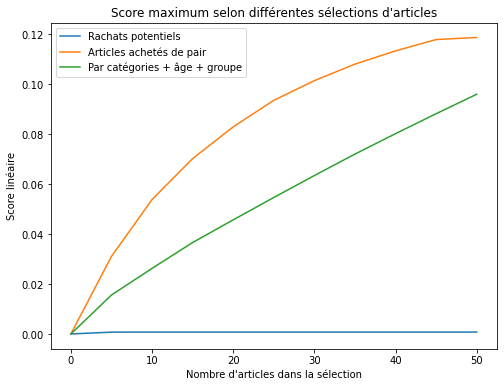

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

x = np.arange(0, 51, 5)

plt.figure(figsize = (8, 6))
#plt.plot(x, best_articles_curve, label = "Ventes générales")
plt.plot(x, repurchase_curve, label = "Rachats potentiels")
plt.plot(x, pairs_curve, label = "Articles achetés de pair")
plt.plot(x, cross_curve, label = "Par catégories + âge + groupe")

plt.xlabel("Nombre d'articles dans la sélection")
plt.ylabel("Score linéaire")
plt.title("Score maximum selon différentes sélections d'articles")
plt.legend()

plt.show()

**Observations**
- La liste des articles achetés de pair semble très prometteuse.
- La liste croisée catégorie / âge / groupe est sensiblement meilleure que chaque critère un à un, sans pour autant doubler ou tripler le score maximum.
- La courbe des rachats potentiels semble anormalement basse, **sans doute parce qu'elle concerne qu'une faible partie des clients**

-> Il faudrait retracer la courbe des achats potentiels en ne prenant que les clients qui ont des articles dans la liste.

#### Retraçage de la courbe des rachats
Pondérées par le nombre d'utilisateurs qui ont des éléments dans la liste

In [16]:
repurchase_curve_adjusted = [0]

length = len(already_purchased_list['list'])

score = 0

already_purchased_list_length = already_purchased_list['list'].apply(lambda x: len(x))

for i in np.arange(0, 50, 1):
    length = len(already_purchased_list[already_purchased_list_length > i])
    
    if length == 0:
        repurchase_curve_adjusted.append(
            score
        )
        continue
    
    print(f"\r Calcul pour les articles 1-{i + 1}", end="")
    score += get_maximum_score(
            validation_purchases['purchase_list'],
            already_purchased_list['list'].apply(lambda x: x[i: i + 1])
        ).sum() / length
        
    repurchase_curve_adjusted.append(
        score
    )


 Calcul pour les articles 1-11

In [17]:
# Courbes plus précises
cross_curve = max_score_curve(validation_purchases['purchase_list'], cross_list, 50, 1)
pairs_curve = max_score_curve(validation_purchases['purchase_list'], pairs_list['list'], 50, 1)

 Calcul pour les articles 1-49

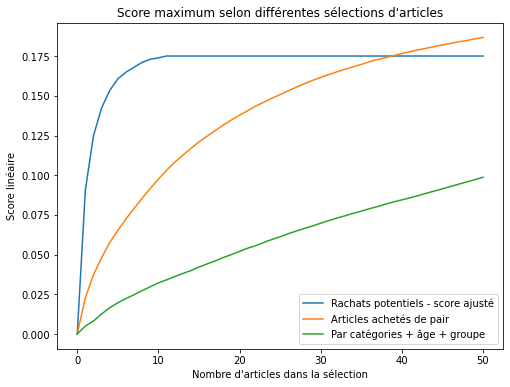

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline



x = np.arange(0, 51, 1)

plt.figure(figsize = (8, 6))
#plt.plot(x, best_articles_curve, label = "Ventes générales")
plt.plot(x, repurchase_curve_adjusted, label = "Rachats potentiels - score ajusté")
plt.plot(x, pairs_curve, label = "Articles achetés de pair")
plt.plot(x, cross_curve, label = "Par catégories + âge + groupe")

plt.xlabel("Nombre d'articles dans la sélection")
plt.ylabel("Score linéaire")
plt.title("Score maximum selon différentes sélections d'articles")
plt.legend()

plt.show()

**Observations**
- Les courbes sont globalement concaves, ce qui laisse supposer que les principes de scoring choisis sont plutôt bons. Juste la sélection croisée pourrait peut-être être améliorée.
- le gain potentiel de liste des rachats est très significatif jusqu'à 7 articles.
- Au delà de 25-30 articles, les courbes orange et vertes semblent parallèles

#### Détermination du nombre optimal d'articles de chaque liste

In [19]:
def amount_of_each_list(score_list_1, score_list_2, score_list_3, length):
    i_1 = 1
    i_2 = 1
    i_3 = 1
    
    for n in range(0, length):
        score_1 = score_list_1[i_1] - score_list_1[i_1 - 1]
        score_2 = score_list_2[i_2] - score_list_2[i_2 - 1]
        score_3 = score_list_3[i_3] - score_list_3[i_3 - 1]
        
        
        if score_1 >= score_2 and score_1 >= score_3 :
            i_1 += 1
        elif score_2 >= score_3 :
            i_2 += 1
        else :
            i_3 += 1
            
    return i_1 - 1, i_2 - 1, i_3 - 1
            

In [20]:
i_1, i_2, i_3 = amount_of_each_list(repurchase_curve_adjusted, pairs_curve, cross_curve, 12)
print(f"Pour une liste de 12 éléments, prendre : \n {i_1} rachats \n {i_2} articles appairés, \n {i_3} articles de la liste croisée. ")

Pour une liste de 12 éléments, prendre : 
 5 rachats 
 7 articles appairés, 
 0 articles de la liste croisée. 


In [21]:
i_1, i_2, i_3 = amount_of_each_list(repurchase_curve_adjusted, pairs_curve, cross_curve, 50)
print(f"Pour une shortlist de 50 éléments, prendre : \n {i_1} rachats \n {i_2} articles appairés, \n {i_3} articles de la liste croisée. ")

Pour une shortlist de 50 éléments, prendre : 
 8 rachats 
 29 articles appairés, 
 13 articles de la liste croisée. 


#### Évaluation de la liste finale

In [23]:
validation_purchases['cross_list'] = cross_list
validation_purchases['pair_list'] = pairs_list['list']
validation_purchases['repurchase_list'] = already_purchased_list['list']

In [24]:
validation_purchases['length'] = validation_purchases['cross_list'].apply(lambda x: len(x))
validation_purchases['length'].value_counts()
validation_purchases = validation_purchases[validation_purchases['length'] == 100]

In [28]:
def process_shortlist(raw):
    shortlist = []
    
    i_1 = 0
    i_2 = 0
    i_3 = 0
    
    while (len(shortlist) < 50) & (i_3 < len(raw['cross_list'])):
        if i_1 < 8 and i_1 < len(raw['repurchase_list']):
            article_id = raw['repurchase_list'][i_1]
            i_1 += 1
        elif i_2 < 27 and i_2 < len(raw['pair_list']):
            article_id = raw['pair_list'][i_2]
            i_2 += 1
        else:
            article_id = raw['cross_list'][i_3]
            i_3 += 1
    
        if article_id not in shortlist:
            shortlist.append(article_id)
            
    return shortlist

validation_purchases['shortlist'] = validation_purchases.apply(lambda x: process_shortlist(x), axis = 1)

In [29]:
max_score = get_maximum_score(validation_purchases['purchase_list'], validation_purchases['shortlist']).sum() / len(validation_purchases)

print("Score linéaire maximal obtenu par la shortlist: ", max_score)

Score linéaire maximal obtenu par la shortlist:  0.2512086383694438


### Conclusion

- Entraîner un algorithme sur la shortlist permettrait d'obtenir un score linéaire maximal de 0.25. Cette limite est très supérieure aux scores obtenus sur la compétition (~0.035) et nous pouvons donc la considérer comme acceptable.
- Le score maximal obtenu pour des listes faisant intervenir des notions séquentielles, de relations entre les articles (rachat + articles appairés) et / ou d'historique d'achat du client, nous conforte dans l'idée qu'un modèle de type RNN / GNN serait approprié sur cette problématique.